# 0.0 IMPORTS

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split

## 0.1 Load Data

In [2]:
df_raw = pd.read_parquet('../../projeto/data_featured/data_featured.parquet')

In [3]:
df_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,SK_DPD_POS,SK_PREV_POS,ACCEPTED_CREDICT_PA,LAST_CONTRACT_STATUS_PA,AVG_AMOUNT_ANNUITY_PA,TTL_AMOUNT_ANNUITY_PA,SK_PREV_PA,MAX_AMT_APPLICATION_PA,MAX_AMT_CREDIT_PA,LAST_REJECTED_PA
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,19.0,1.000000,Approved,9251.775,9251.775,1.0,179055.0,179055.0,XAP
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,28.0,0.949329,Approved,56553.990,169661.970,3.0,900000.0,1035882.0,XAP
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,4.0,1.207699,Approved,5357.250,5357.250,1.0,24282.0,20106.0,XAP
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,21.0,1.010763,Refused,23651.175,141907.050,9.0,688500.0,906615.0,LIMIT
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,66.0,0.969650,Approved,12278.805,73672.830,6.0,247500.0,284400.0,XAP


# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## Data Shape

In [11]:
df1.shape

(307511, 147)

## Check NaN

In [14]:
df1.isna().sum().sort_values(ascending=False).head(40)

CC_PAYMENT_DIV_MINIMAL      246824
CC_LIMIT_USAGE              221475
CC_LAST_NAME_CONTRACT       220606
CC_MAX_DPD                  220606
CC_PREV_CRED_QTT            220606
LAST_STATUS_DPD_60_B        215280
LAST_STATUS_B               215280
COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
FLOORSMIN_MEDI              208642
FLOORSMIN_MODE              208642
FLOORSMIN_AVG               208642
YEARS_BUILD_MODE            204488
YEARS_BUILD_MEDI            204488
YEARS_BUILD_AVG             204488
OWN_CAR_AGE                 202929
LANDAREA_MEDI               182590
LANDAREA_AVG                182590
LANDAREA_MODE               182590
BASEMENTAREA_AVG            179943
BASEMENTAREA_MODE   

## Target Distribution

In [15]:
df1[['TARGET']].describe()

,TARGET
count,307511.000000
mean,0.080729
std,0.272419
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# 2.0 FEATURE SELECTOR

In [16]:
df2 = df1.copy()

In [19]:
X_train, X_val, y_train, y_val = train_test_split(df2.drop(['TARGET','SK_ID_CURR'], axis=1), df2['TARGET'], test_size=0.2, random_state=42, stratify=df2['TARGET'])

In [49]:
categorical_cols = []
for cols in X_train.columns:
    if X_train[cols].dtype == 'object':
        categorical_cols.append(cols)

for feature in categorical_cols:
    X_train[feature] = X_train[feature].astype('category')
    X_val[feature] = X_val[feature].astype('category')
    

In [54]:
d_train = lgbm.Dataset(X_train, label=y_train, categorical_feature=categorical_cols) 
params = {
    'objective': 'binary', 
    'metric': 'binary_logloss',
}

gbm = lgbm.train(params, d_train, num_boost_round=500)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15202
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


In [56]:
X_val[['ORGANIZATION_TYPE']].head()

,ORGANIZATION_TYPE
256571,Transport: type 4
191493,Government
103497,Industry: type 4
130646,Self-employed
211898,Government


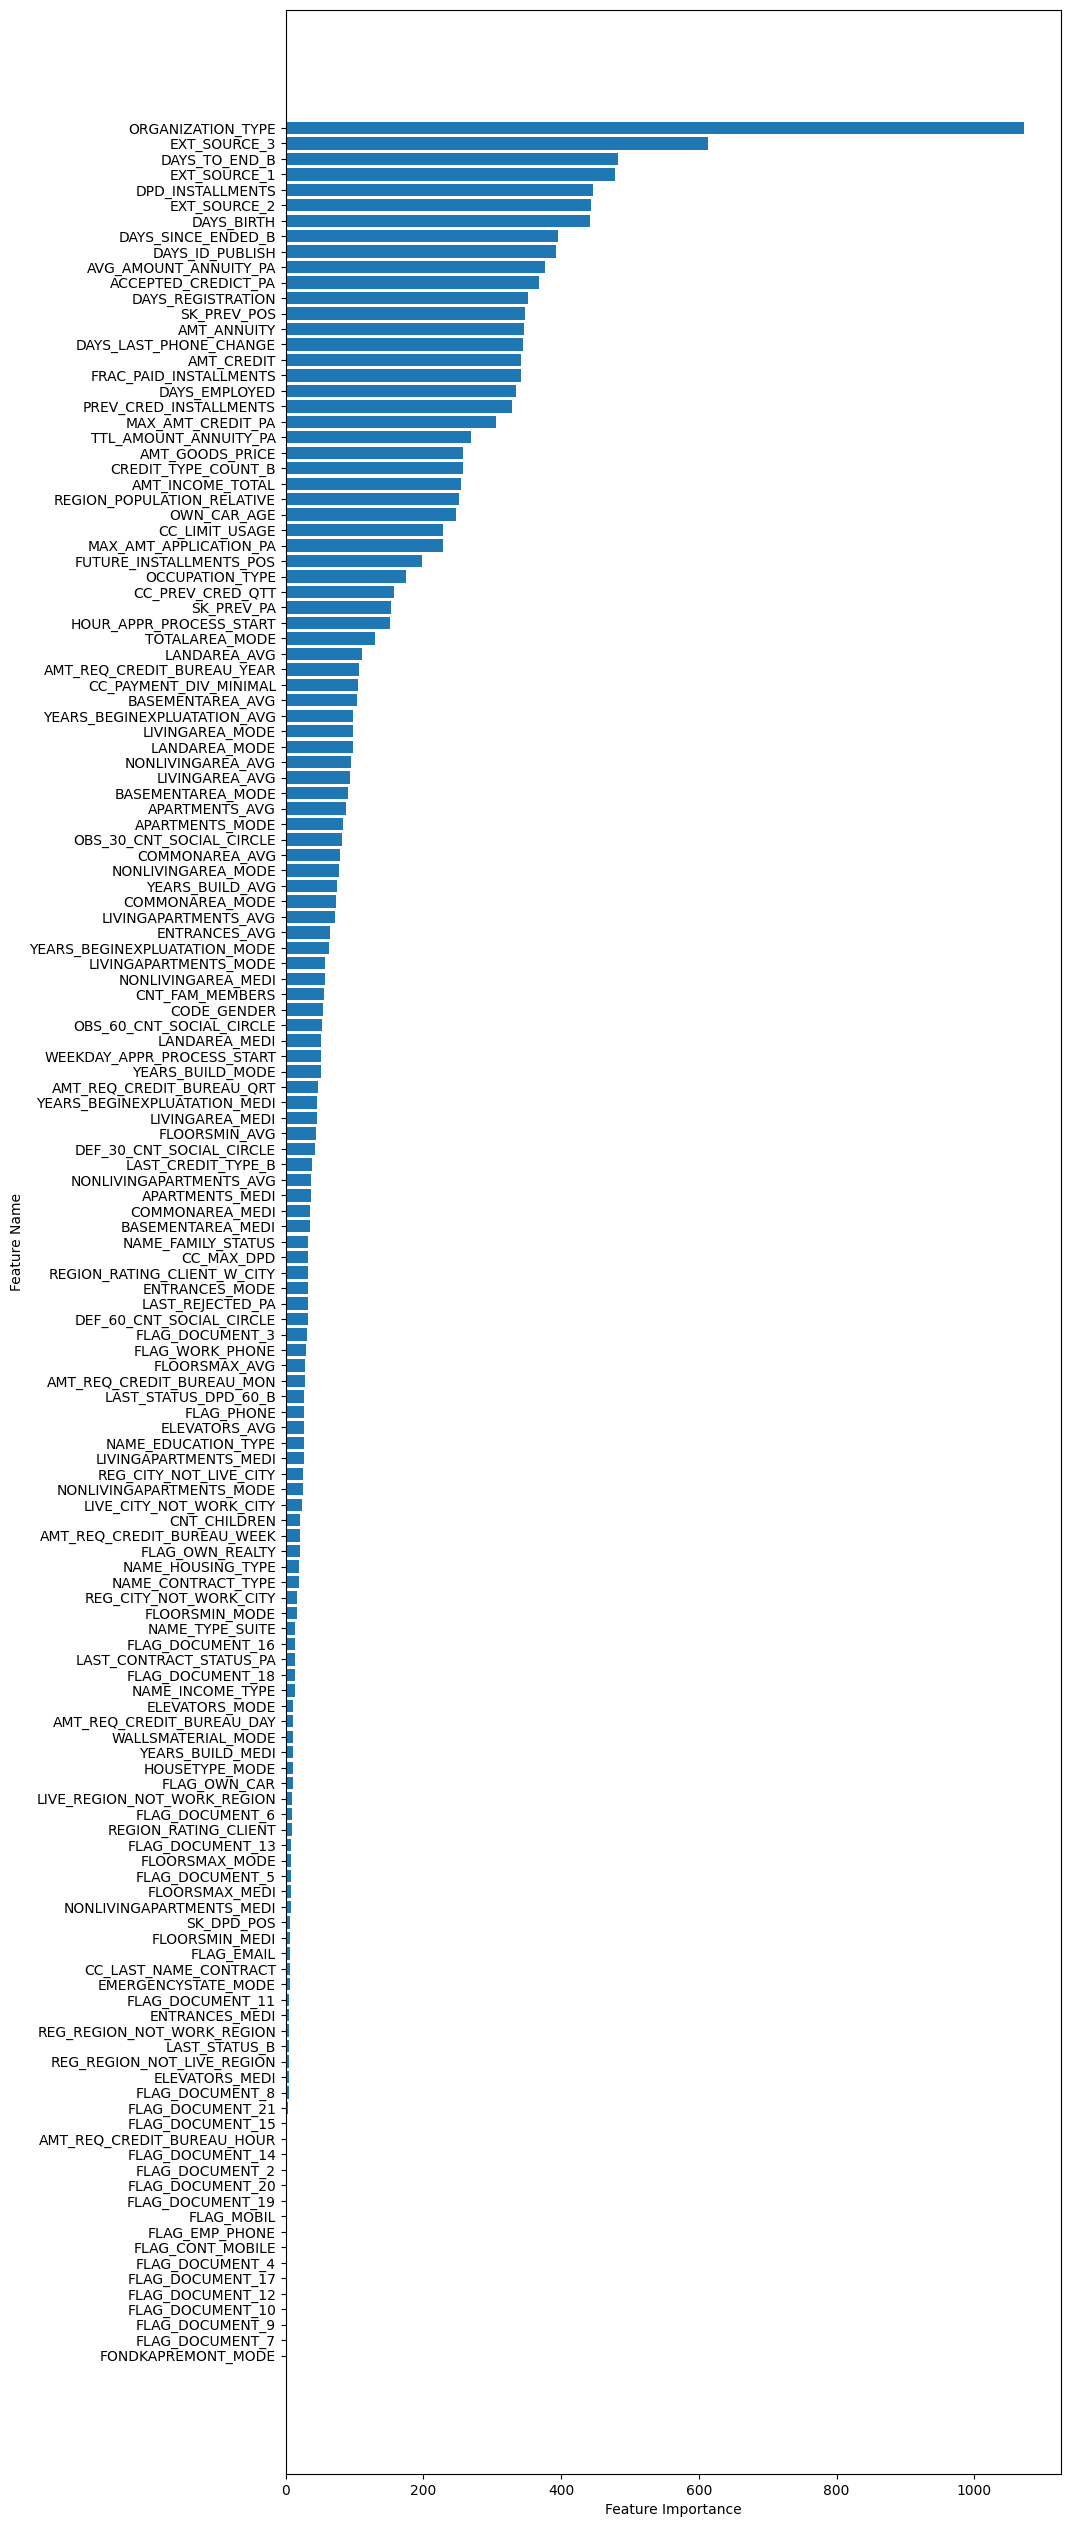

In [55]:
importance = gbm.feature_importance()
feature_names = gbm.feature_name()
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importance
})
feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)
plt.figure(figsize=(10, 32))
plt.barh(feature_importance_df['Feature Name'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

In [70]:
feature_names = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)[['Feature Name']].reset_index(drop=True)['Feature Name'].tolist()


In [71]:
feature_names

['ORGANIZATION_TYPE',
 'EXT_SOURCE_3',
 'DAYS_TO_END_B',
 'EXT_SOURCE_1',
 'DPD_INSTALLMENTS',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'DAYS_SINCE_ENDED_B',
 'DAYS_ID_PUBLISH',
 'AVG_AMOUNT_ANNUITY_PA',
 'ACCEPTED_CREDICT_PA',
 'DAYS_REGISTRATION',
 'SK_PREV_POS',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_CREDIT',
 'FRAC_PAID_INSTALLMENTS',
 'DAYS_EMPLOYED',
 'PREV_CRED_INSTALLMENTS',
 'MAX_AMT_CREDIT_PA']